# Advanced Research Module Usage

## Roadmap

1. Introduction 
    * Basic example
        * 1 pipeline with fixed parameters
            * creating research
            * running several repetitions of an experiment
            * viewing research results
            * saving and loading research
    * Runnung experiments with different parameters aka grid
        * 1 pipeline with variable parameters
            * creating and viewing grids
            * viewing filtered research results
    * More complex execution strategies
        * 2 pipelines, train & test + function + grid
            * adding test pipeline
            * defining pipeline execution frequency
            * adding functions

1. Advanced topics **<- You are here**
    * Reducing extra dataset loads
        * 1 pipeline with root and branch + grid
    * Performance
        * execution tasks managing
    * Cross-validation

1. Combining it all together
    * Super complex Research

## Reducing Extra Dataset Loads

In [1]:
import sys
sys.path.append('../../..')

import os
import shutil


import matplotlib
%matplotlib inline

from batchflow import Pipeline, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option

In [2]:
BATCH_SIZE=64
ITERATIONS=1000
TEST_EXECUTE_FREQ=100

### Running Research Sequentially

In previous tutorial we learned how to use Research to run experimetrs multiple times and with varying parameters.

Firstly we define a dataset to work with

In [3]:
mnist = MNIST()
train_root = mnist.train.p.run_later(BATCH_SIZE, shuffle=True, n_epochs=None)

Then we define a grid of parameters whose nodes will be used to form separate experiments

In [4]:
grid = Option('layout', ['cna', 'can']) * Option('bias', [True, False])        

These parameters can be passed to model's configs using named expressions. 

In [5]:
model_config={
    'inputs/images/shape': (28, 28, 1),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
}

After that we define a pipeline to run during our experiments. We initialise a pipeline variable `'loss'` to store loss on each iteration

In [6]:
train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
)

Finally we define a Research that runs the pipeline substituting its parameters using different nodes of the `grid`, and saves values of the `'loss'` named expressions to results.

In [7]:
if os.path.exists('simple_research'):
    shutil.rmtree('simple_research')

research = (Research()
            .add_pipeline(train_root + train_template, variables='loss')
            .add_grid(grid))

research.run(n_reps=4, n_iters=10, name='simple_research', bar=True)


Research simple_research is starting...


  0%|          | 0/160 [00:00<?, ?it/s]

Distributor has 16 jobs with 10 iterations. Totally: 160


100%|██████████| 160/160 [02:40<00:00,  1.00s/it]


16 experiments are run (4 grid nodes x 4 repetitions) each consisting of 10 iterations.

We can load results of the research and see that the table has 160 entries.

In [8]:
research.load_results().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 9
Data columns (total 6 columns):
bias          160 non-null object
iteration     160 non-null int64
layout        160 non-null object
loss          160 non-null float64
name          160 non-null object
repetition    160 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.8+ KB


### Branches: Reducing Data Loading and Preprocessing

Each experiment can be divided into 2 stages: root stage that is roughly same for all experiments (for example, data loading and preprocessing) and branch stage that varies. If data preprocessing takes significant time one can use the batches generated on a root stage to feed to several branches that belong to different experiments. 

To do so, one should pass `root` and `branch` parameters to `add_pipeline()` and define number of branches per root via `branches` parameter of `run()`.

A root with corresponding branches is called a **job**. Note that different roots produce different batches due to shuffling.

In [9]:
if os.path.exists('no_extra_dataload_research'):
    shutil.rmtree('no_extra_dataload_research')
    
research = (Research()
            .add_pipeline(root=train_root, branch=train_template, variables='loss')
            .add_grid(grid))

research.run(n_reps=4, n_iters=10, branches=8, name='no_extra_dataload_research', bar=True)


Research no_extra_dataload_research is starting...


  0%|          | 0/20 [00:00<?, ?it/s]

Distributor has 2 jobs with 10 iterations. Totally: 20


100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


Scince every root now assigned to 8 branches, there are only 2 jobs.

We can see that the whole research duration reduced.
In this toy example we use only 10 iterations to make the effect of reduced dataset load more visible.

The numbers of results entries is the same. 

In [10]:
research.load_results().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 9
Data columns (total 6 columns):
bias          160 non-null object
iteration     160 non-null int64
layout        160 non-null object
loss          160 non-null float64
name          160 non-null object
repetition    160 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.8+ KB


### Functions on Root

If each job has several branches, they are all executed in parallel threads. To run a function on root, one should add it with `on_root=True`.

Functions on root have required parameters `iteration` and `experiments` and optional keyword parameters. They are not allowed to return anything

In [11]:
if os.path.exists('on_root_research'):
    shutil.rmtree('on_root_research')
    
def function_on_root(iteration, experiments):
    print('on root')
    
research = (Research()
            .add_function(function_on_root, execute="#0", on_root=True)
            .add_pipeline(root=train_root, branch=train_template, variables='loss')
            .add_grid(grid)
           )

research.run(n_reps=4, branches=8, n_iters=ITERATIONS, name='on_root_research', bar=True)

Research on_root_research is starting...


  0%|          | 0/2000 [00:00<?, ?it/s]

Distributor has 2 jobs with 1000 iterations. Totally: 2000
on root


  0%|          | 1/2000 [00:20<11:24:03, 20.53s/it]

on root


100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]


## Improving Performance

Research can ran experiments in parallel if number of workers if defined in `workers` parameter. 
Each worker starts in a separate process and performs one or several jobs assigned to it. Moreover if several GPU's are accessible one can pass indices of GPUs to use via `gpu` parameter.

Following parameters are also useful to control research execution:
* `timeout` in `run` specifies time in minutes to kill non-responding job, default value is 5
* `trials` in `run` specifies number of attempts to restart a job, default=2
* `dump` in `add_pipeline`, `add_function` and `get_metrics` tells how often results are written to disk and cleared. By default results are dumped on the last iteration, but if they consume too much memory one may want to do it more often. The format is same as `execute`

In [12]:
model_config={
    'device': C('device'), # it's technical parameter for TFModel
    'inputs/images/shape': (28, 28, 1),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
)

test_root = mnist.test.p.run_later(BATCH_SIZE, shuffle=True, n_epochs=1) #Note  n_epochs=1

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics')))

research = (Research()
            .add_pipeline(root=train_root, branch=train_template, variables='train_loss', name='train_ppl',
                          dump=TEST_EXECUTE_FREQ)
            .add_pipeline(root=test_root, branch=test_template, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', 
                         execute=TEST_EXECUTE_FREQ,
                         dump=TEST_EXECUTE_FREQ,)
            .add_grid(grid))


if os.path.exists('faster_research'):
    shutil.rmtree('faster_research')

research.run(n_reps=4, n_iters=ITERATIONS, name='faster_research', bar=True, 
             branches=2, workers=2, gpu=[4,5], 
             timeout=2, trials=1)

Research faster_research is starting...


  0%|          | 0/8000 [00:00<?, ?it/s]

Distributor has 8 jobs with 1000 iterations. Totally: 8000


100%|██████████| 8000/8000 [06:54<00:00, 19.28it/s]


In [13]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16160 entries, 0 to 9
Data columns (total 7 columns):
accuracy      160 non-null float64
bias          16160 non-null object
iteration     16160 non-null int64
layout        16160 non-null object
name          16160 non-null object
repetition    16160 non-null int64
train_loss    16000 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1010.0+ KB


## Cross-validation

One can easyly perform cross-validation with Research

Firstly we will define a dataset: we will use train subset of MNIST

In [14]:
mnist_train = MNIST().train

Next, we define our train and test pipelines. When performing cross-validation, Research will automatically split the dataset given and feed the folds to pipelines, so we will rather define pipeline templates that will wait for a dataset to work with. In contrast with previous tutorials we are adding `run` method to pipeline templates, not dataset pipelines.

In [21]:
model_config={
    'inputs/images/shape': (28, 28, 1),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
).run_later(BATCH_SIZE, shuffle=True, n_epochs=None)

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics'))
).run_later(BATCH_SIZE, shuffle=True, n_epochs=1)

We are now defining our Research object. To use cross-validation we should pass `dataset` and `part` parameters to `add_pipeline` methods. We don't pass any dataset to `root` explicitely scince this is now Research that cares for data.

Next, we call `run` with `n_splits` parameter that defines the number of cv folds. We can also pass `shuffle` to specify whether to shuffle the dataset before splitting. `shuffle` can be bool, int, `numpy.random.RandomState` or callable, its default value is *False* which means no shuffling.

In [16]:
grid = Option('layout', ['cna', 'can'])

research = (Research()
            .add_pipeline(train_template, dataset=mnist_train, part='train', variables='train_loss', name='train_ppl')
            .add_pipeline(test_template, dataset=mnist_train, part='test', name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy', returns='accuracy', 
                         execute=TEST_EXECUTE_FREQ)
            .add_grid(grid))

if os.path.exists('cv_research'):
    shutil.rmtree('cv_research')
    
research.run(n_iters=ITERATIONS,
             n_splits=3, shuffle=True, 
             name='cv_research', bar=True, workers=1, gpu=[4])

Research cv_research is starting...


  0%|          | 0/6000 [00:00<?, ?it/s]

Distributor has 6 jobs with 1000 iterations. Totally: 6000


100%|██████████| 6000/6000 [04:42<00:00, 21.20it/s]


We can now load results, specifying which folds to get if needed

In [17]:
results = research.load_results(folds=0)
results.sample(5)

,accuracy,cv_split,iteration,layout,name,repetition,train_loss
579,NaN,0,579,cna,train_ppl,0,0.089246
44,NaN,0,44,cna,train_ppl,0,0.840914
0,NaN,0,0,cna,train_ppl,0,4.148561
145,NaN,0,145,cna,train_ppl,0,0.190070
326,NaN,0,326,cna,train_ppl,0,0.092601


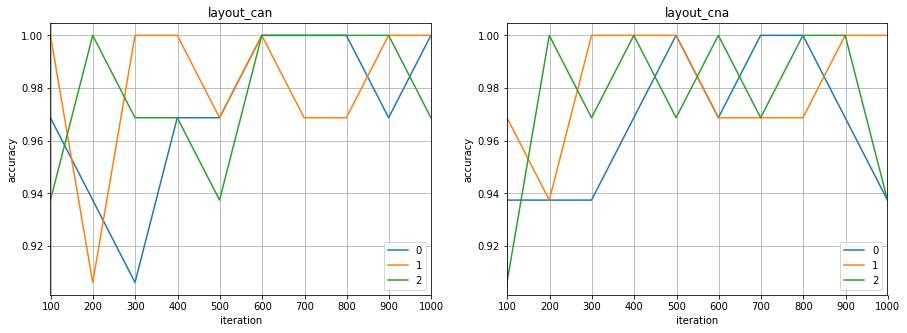

In [19]:
from matplotlib import pyplot as plt
test_results = research.load_results(names= 'test_ppl_metrics', use_alias=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, (config, df) in enumerate(test_results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='cv_split', values='accuracy').plot(ax=ax[y])
    ax[y].set_title(config)
    ax[y].set_xlabel('iteration')
    ax[y].set_ylabel('accuracy')
    ax[y].grid(True)
    ax[y].legend()

### Cross Validation with Extra Performance Settings
We can still use branch-root division to preprocess the data

<font color='red'> **CHECK** </font>

In [27]:
# augmentation_pipeline = Pipeline().salt(p=0.5)#.run_later(BATCH_SIZE, shuffle=True, n_epochs=None)

# # train_template = (Pipeline()
# #             .init_variable('train_loss')
# #             .init_model('dynamic', VGG7, 'conv', config=model_config)
# #             .to_array()
# #             .train_model('conv', 
# #                             images=B('images'), labels=B('labels'),
# #                             fetches='loss', save_to=V('train_loss', mode='w'))
# # )

# research = (Research()
#             .add_pipeline(root=augmentation_pipeline, branch=train_template,
# #                         augmentation_pipeline+train_template,
#                           dataset=mnist_train, part='train', 
#                           variables='train_loss', name='train_ppl')
#             .add_pipeline(test_template, dataset=mnist_train, part='test', name='test_ppl',
#                           execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
#             .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy', returns='accuracy', 
#                          execute=TEST_EXECUTE_FREQ)
#             .add_grid(grid))

# if os.path.exists('cv_branches_research'):
#     shutil.rmtree('cv_branches_research')
# research.run(n_iters=ITERATIONS,
#              n_splits=3, shuffle=True,
#              workers=2, gpu=[4,5], 
# #              branches=2, 
#              name='cv_branches_research', bar=True)
# research.load_results().info()

Research cv_branches_research is starting...


  0%|          | 0/6000 [00:00<?, ?it/s]

Distributor has 6 jobs with 1000 iterations. Totally: 6000


100%|██████████| 6000/6000 [01:57<00:00, 50.91it/s]


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame